# Model training

- Loading data from pickles
- Splitting the data into train, validation and test datasets
- Removing black masks (if required)
- Data augmentation (if required)
- Jaccard Metric function
- Model architecture (U-Net)
- Model training
- Model evaluation
- Results visualization

### Set parameters
Training the model with default parameters (for 50 epochs) should get you to about 40-45% jaccard on training dataset and around 25-30% on validation/test. On NC6 it should be about 3 hours?

BATCH_NORM and USE_DROPOUT is set to True to prevent model from overfitting too fast. Without those parameters model is overfitting very fast on training dataset.

In [1]:
SAT_IMG_SIZE = 3200 
IMG_SIZE = 400 # 160, 400 or 800?
OVERLAPING_CROPS = True # True/False
if OVERLAPING_CROPS:
    STEP = IMG_SIZE//2
    DATASET_X_NAME = "X_%s_overlap.npy" % (IMG_SIZE)
    DATASET_Y_NAME = "Y_%s_overlap.npy" % (IMG_SIZE)
else:
    STEP = IMG_SIZE
    DATASET_X_NAME = "X_%s.npy" % (IMG_SIZE)
    DATASET_Y_NAME = "Y_%s.npy" % (IMG_SIZE)

In [2]:
# data prep parameters
REMOVE_BLACK_MASKS_FROM_TRAIN = False # you want to have some fully black masks - your network is learning from them too
DATA_AUGMENTATION = True

# constant for jaccard metric
SMOOTH = 1e-12 

# training parameters
LOAD_PREVIOUS_WEIGHTS = True # use to load previously trained model
BATCH_SIZE = 16 # highly depends on the size of your images. the bigger the image the smaller batch_size you will use to avoid OOM
CHECKPOINT_FILENAME = 'ch8_unet_' + DATASET_X_NAME +'.hdf5'
MODEL_FILENAME = 'model_'+ DATASET_X_NAME +'.h5'
EPOCHS = 50
LEARNING_RATE = 0.01

# network parameters
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_NORM = True
USE_DROPOUT = True
DROPOUT = 0.05
DROPOUT_CHANGE_PER_LAYER = 0.05 # change of dropout value for each U-Net layer (negative value will decrease dropout for each layer)
UPSAMPLE_MODE = 'DECONV' # or anything else for simple upsampling


# Load dataset

In [3]:
import pickle

with open(r"dataset/kaggle/" + DATASET_X_NAME, "rb") as input_file:
    x = pickle.load(input_file)
    
with open(r"dataset/kaggle/" + DATASET_Y_NAME, "rb") as input_file:
    y = pickle.load(input_file)

In [4]:
x.shape

(5175, 400, 400, 3)

In [5]:
y.shape

(5175, 400, 400)

In [6]:
y = y.reshape((y.shape[0], y.shape[1], y.shape[2], 1))

In [7]:
y.shape

(5175, 400, 400, 1)

In [8]:
x = x.astype('float32')
y = y.astype('float32')
x /= 255

### Split dataset into train, validation and test 
I'm splitting the data into 3 datasets (train, validation and test).
Training is used for training, validation to validate after each epoch of training and test is used to evaluate the model after the training

I'm splitting my data based on the whole satelite images. First 19 goes to train, another 2 goes to validation and another 2 goes to test

In [9]:
crops_in_sat_count = x.shape[0] // 23 # 23 is the total number of sat images after removing the 2 with completely black masks
crops_in_sat_count

225

In [10]:
X_train = x[:crops_in_sat_count*19] # 19 first images goes to training
y_train = y[:crops_in_sat_count*19]

X_val = x[crops_in_sat_count*19:crops_in_sat_count*21] # 2 another images goes to validation
y_val = y[crops_in_sat_count*19:crops_in_sat_count*21]

X_test = x[crops_in_sat_count*21:] # 2 another images goes to test
y_test = y[crops_in_sat_count*21:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(4275, 400, 400, 3) (4275, 400, 400, 1)
(450, 400, 400, 3) (450, 400, 400, 1)
(450, 400, 400, 3) (450, 400, 400, 1)


# Remove fully black masks from the training dataset

In [11]:
X_train.shape

(4275, 400, 400, 3)

In [12]:
if REMOVE_BLACK_MASKS_FROM_TRAIN:
    import numpy as np

    X_train_bis = X_train
    y_train_bis = y_train
    for i in range(0, X_train.shape[0]):
        if y_train_bis[i].sum() == 0:
            X_train_bis[i] = np.zeros(X_train_bis[i].shape, dtype=np.float32)


    X_train = np.array([f for f in X_train_bis if f.sum() > 0])
    y_train = np.array([f for f in y_train_bis if f.sum() > 0])

In [13]:
print(X_train.shape, y_train.shape)

(4275, 400, 400, 3) (4275, 400, 400, 1)


# Data Augmentation

In [14]:
if DATA_AUGMENTATION:
    from keras.preprocessing.image import ImageDataGenerator

    # Runtime data augmentation
    def get_augmented(
        X_train, 
        Y_train, 
        X_val,
        Y_val,
        batch_size=32, 
        seed=0, 
        data_gen_args = dict(
            #rotation_range=180.,
            #width_shift_range=0.1,
            #height_shift_range=0.1,
            #shear_range=0.2,
            #zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='constant'
        )):


        # Train data, provide the same seed and keyword arguments to the fit and flow methods
        X_datagen = ImageDataGenerator(**data_gen_args)
        Y_datagen = ImageDataGenerator(**data_gen_args)
        X_datagen.fit(X_train, augment=True, seed=seed)
        Y_datagen.fit(Y_train, augment=True, seed=seed)
        X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
        Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)


        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator()
        Y_datagen_val = ImageDataGenerator()
        X_datagen_val.fit(X_val, augment=True, seed=seed)
        Y_datagen_val.fit(Y_val, augment=True, seed=seed)
        X_val_augmented = X_datagen_val.flow(X_val, batch_size=batch_size, shuffle=True, seed=seed)
        Y_val_augmented = Y_datagen_val.flow(Y_val, batch_size=batch_size, shuffle=True, seed=seed)


        # combine generators into one which yields image and masks
        train_generator = zip(X_train_augmented, Y_train_augmented)
        val_generator = zip(X_val_augmented, Y_val_augmented)

        return train_generator, val_generator
    
    train_generator, val_generator = get_augmented(X_train, y_train, X_val, y_val, batch_size=BATCH_SIZE)

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Visualize a sample augmentated batch

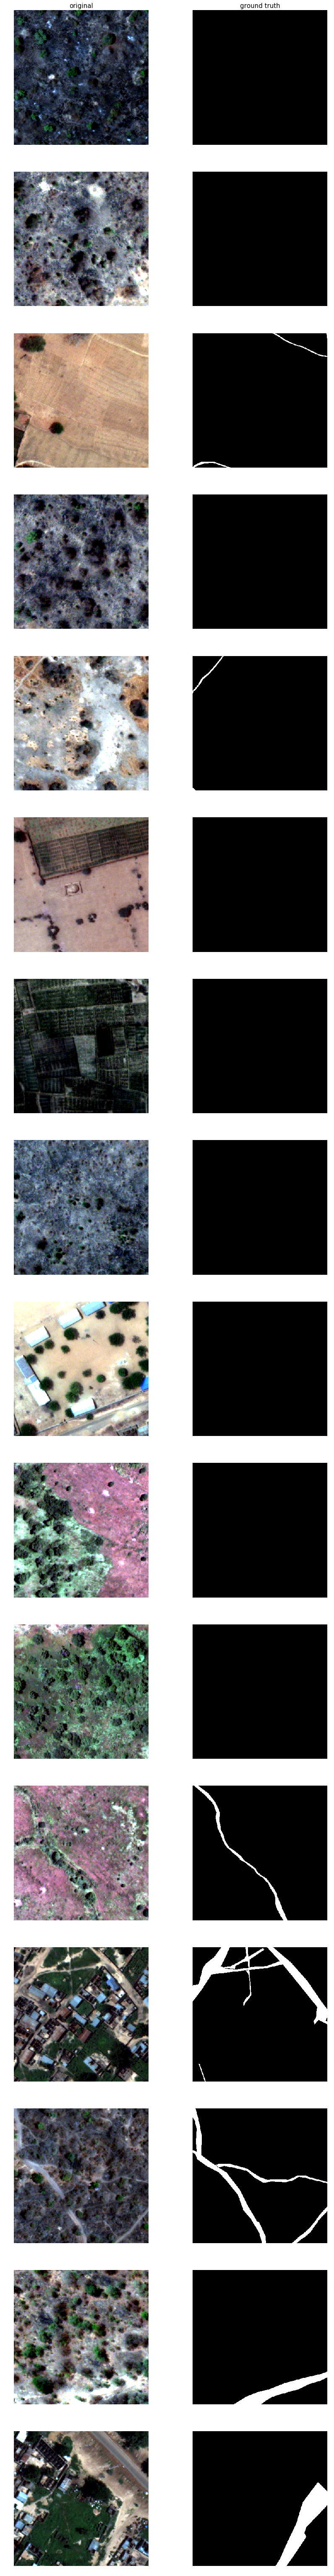

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

if DATA_AUGMENTATION:
    xx, yy = next(train_generator)

    import matplotlib.pyplot as plt
    import random

    fig, axes = plt.subplots(xx.shape[0], 2, figsize=(2*7, xx.shape[0]*7))
    axes[0, 0].set_title("original", fontsize=15) 
    axes[0, 1].set_title("ground truth", fontsize=15) 
    mm = 0
    for m in range(0, xx.shape[0]):
        axes[m, 0].imshow(xx[mm])
        axes[m, 0].set_axis_off()
        axes[m, 1].imshow(yy[mm].reshape((IMG_SIZE,IMG_SIZE)), cmap='gray')
        axes[m, 1].set_axis_off()
        mm += 1

# Imports and training

In [16]:
from keras.models import Model
from keras.layers import Input, concatenate, merge, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score


# Jaccard metric helper funtions

In [17]:
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    jac = (intersection + SMOOTH) / (union - intersection + SMOOTH)
    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos)
    union = K.sum(y_true + y_pred)
    jac = (intersection + SMOOTH) / (union - intersection + SMOOTH)
    return K.mean(jac)

# Create model function and helper functions

In [18]:
from keras.regularizers import *
from keras.layers import *


def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def conv2d_block(
    inputs, 
    use_batch_norm=True, 
    use_dropout=True, 
    dropout=0.5, 
    filters=16, 
    kernel_size=(3, 3), 
    activation='relu', 
    kernel_initializer='he_normal', 
    padding='same'):
    
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if use_dropout:
        c = Dropout(dropout)(c)
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c

In [19]:
def get_unet(
    input_shape,
    use_batch_norm=True, 
    upsample_mode='DECONV', 
    use_dropout=True, 
    use_dropout_on_upsampling=False, 
    dropout=0.1, 
    dropout_change_per_layer=0.0,
    filters=16,
    nm_layers=4):
    
    if upsample_mode=='DECONV':
        upsample=upsample_conv
    else:
        upsample=upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)    
    
    # it can be done iteratively but im leaving it like that for better clarity and transparency    
    #### downsampling layers     
    c1 = conv2d_block(inputs=inputs, filters=filters, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout=dropout)
    p1 = MaxPooling2D((2, 2)) (c1)
    
    # start increasing number of filters with each layer and change dropout if required
    dropout += dropout_change_per_layer
    filters = filters*2    
    c2 = conv2d_block(inputs=p1, filters=filters, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout=dropout)
    p2 = MaxPooling2D((2, 2)) (c2)
    
    # increasing number of filters with each layer and change dropout if required
    dropout += dropout_change_per_layer
    filters = filters*2    
    c3 = conv2d_block(inputs=p2, filters=filters, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout=dropout)
    p3 = MaxPooling2D((2, 2)) (c3)
    
    # increasing number of filters with each layer and change dropout if required
    dropout += dropout_change_per_layer
    filters = filters*2    
    c4 = conv2d_block(inputs=p3, filters=filters, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout=dropout)
    p4 = MaxPooling2D((2, 2)) (c4)
    
    # increasing number of filters with each layer and change dropout if required
    dropout += dropout_change_per_layer
    filters = filters*2
    # no max pooling on that last layer
    c5 = conv2d_block(inputs=p4, filters=filters, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout=dropout)
        
    #### upsampling layers
    use_dropout=use_dropout_on_upsampling # by default we dont want dropout on upsampling layers (same as in the original implementation of research paper)
    
    filters //= 2 # decreasing number of filters with each layer    
    u6 = upsample(filters, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(inputs=u6, filters=filters, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout=dropout)
    
    filters //= 2 # decreasing number of filters with each layer    
    u7 = upsample(filters, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])    
    c7 = conv2d_block(inputs=u7, filters=filters, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout=dropout)
    
    filters //= 2 # decreasing number of filters with each layer
    u8 = upsample(filters, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])  
    c8 = conv2d_block(inputs=u8, filters=filters, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout=dropout)
    
    filters //= 2 # decreasing number of filters with each layer
    u9 = upsample(filters, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])  
    c9 = conv2d_block(inputs=u9, filters=filters, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout=dropout)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create and compile model

In [20]:
model = get_unet(
    input_shape=INPUT_SHAPE,
    upsample_mode=UPSAMPLE_MODE, 
    use_batch_norm=BATCH_NORM, 
    use_dropout=USE_DROPOUT, 
    dropout=DROPOUT,
    dropout_change_per_layer=DROPOUT_CHANGE_PER_LAYER
)


from keras_contrib.losses.jaccard import jaccard_distance

model.compile(
    optimizer='adam', 
    loss=jaccard_distance, #'binary_crossentropy', 
    metrics=[jaccard_coef, jaccard_coef_int]
)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 400, 400, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 400, 400, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# Set training callbacks

In [22]:
# model checkpoints
callback_checkpoint = ModelCheckpoint(
    CHECKPOINT_FILENAME, 
    verbose=1, 
    monitor='loss', 
    save_best_only=True
)


from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
    initial_lrate = LEARNING_RATE
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    if lrate < 0.0001:
        lrate = 0.00001
    return lrate

lr_schedule = LearningRateScheduler(step_decay, verbose=1)

In [21]:
# load weights from previous trainings if necessary
if LOAD_PREVIOUS_WEIGHTS:
    model.load_weights(CHECKPOINT_FILENAME)

# Train the model

In [23]:
if DATA_AUGMENTATION:
    history = model.fit_generator(
        train_generator, 
        validation_data=val_generator,
        validation_steps=BATCH_SIZE//2, 
        steps_per_epoch=len(X_train)//(BATCH_SIZE*2), 
        epochs=EPOCHS, 
        verbose=1,
        callbacks=[callback_checkpoint, lr_schedule]
    )
else:
    history = model.fit(
        X_train, 
        y_train, 
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=[callback_checkpoint, lr_schedule]
    )
    
model.save(MODEL_FILENAME)

Epoch 1/50
133/133 [==============================] - 139s 1s/step - loss: 0.5410 - jaccard_coef: 0.0383 - jaccard_coef_int: 0.0247 - val_loss: 0.5468 - val_jaccard_coef: 0.0246 - val_jaccard_coef_int: 0.0148

Epoch 00001: loss improved from inf to 0.54100, saving model to ch8_unet_X_400_overlap.npy_06-10-2018_18-00.hdf5
Epoch 2/50
133/133 [==============================] - 131s 983ms/step - loss: 0.2536 - jaccard_coef: 0.0472 - jaccard_coef_int: 0.0152 - val_loss: 0.2080 - val_jaccard_coef: 0.0367 - val_jaccard_coef_int: 0.0237

Epoch 00002: loss improved from 0.54100 to 0.25356, saving model to ch8_unet_X_400_overlap.npy_06-10-2018_18-00.hdf5
Epoch 3/50
133/133 [==============================] - 131s 989ms/step - loss: 0.1442 - jaccard_coef: 0.0780 - jaccard_coef_int: 0.0458 - val_loss: 0.2435 - val_jaccard_coef: 0.0692 - val_jaccard_coef_int: 0.0694

Epoch 00003: loss improved from 0.25356 to 0.14412, saving model to ch8_unet_X_400_overlap.npy_06-10-2018_18-00.hdf5
Epoch 4/50
133/13


Epoch 00027: loss improved from 0.06052 to 0.06020, saving model to ch8_unet_X_400_overlap.npy_06-10-2018_18-00.hdf5
Epoch 28/50
133/133 [==============================] - 133s 1000ms/step - loss: 0.0584 - jaccard_coef: 0.3362 - jaccard_coef_int: 0.3570 - val_loss: 0.0548 - val_jaccard_coef: 0.2160 - val_jaccard_coef_int: 0.2155

Epoch 00028: loss improved from 0.06020 to 0.05844, saving model to ch8_unet_X_400_overlap.npy_06-10-2018_18-00.hdf5
Epoch 29/50
133/133 [==============================] - 132s 993ms/step - loss: 0.0589 - jaccard_coef: 0.3432 - jaccard_coef_int: 0.3625 - val_loss: 0.0550 - val_jaccard_coef: 0.2345 - val_jaccard_coef_int: 0.2440

Epoch 00029: loss did not improve from 0.05844
Epoch 30/50
133/133 [==============================] - 133s 998ms/step - loss: 0.0571 - jaccard_coef: 0.3471 - jaccard_coef_int: 0.3716 - val_loss: 0.0540 - val_jaccard_coef: 0.2220 - val_jaccard_coef_int: 0.2233

Epoch 00030: loss improved from 0.05844 to 0.05709, saving model to ch8_une

# Plot training history and metrics over epochs

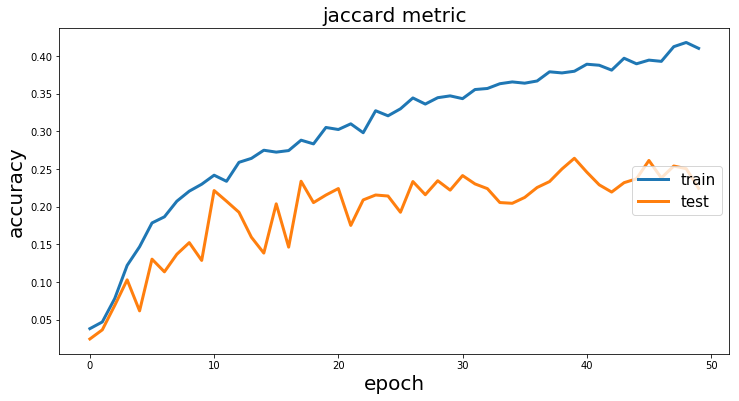

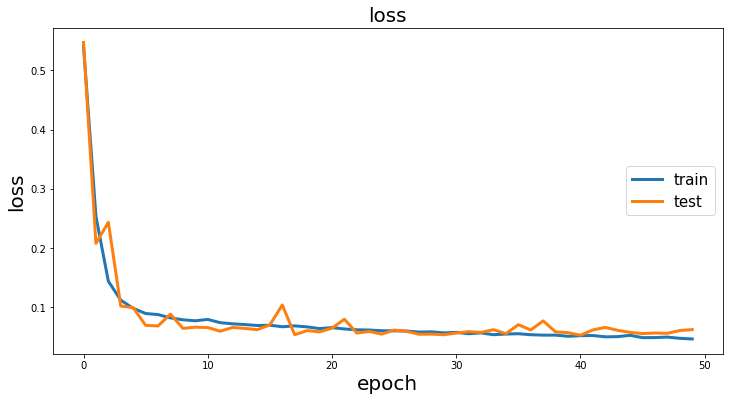

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['jaccard_coef'], linewidth=3)
plt.plot(history.history['val_jaccard_coef'], linewidth=3)
plt.title('jaccard metric', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.xlabel('epoch', fontsize=20)
#plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
#plt.xticks(fontsize=35)
plt.legend(['train', 'test'], loc='center right', fontsize=15)
plt.show()
# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], linewidth=3)
plt.plot(history.history['val_loss'], linewidth=3)
plt.title('loss', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
#plt.yticks(np.arange(0, 0.2, step=0.005), fontsize=35)
#plt.xticks(fontsize=35)
plt.legend(['train', 'test'], loc='center right', fontsize=15)
plt.show()

# Run predictions on test dataset

In [26]:
y_pred = model.predict(X_test)

# Evaluate model

In [25]:
model.evaluate(x=X_test, y=y_test)

450/450 [==============================] - 9s 19ms/step


[0.020869925998979143, 0.2902020596133338, 0.30108067989349363]

# Plot random images, masks and predictions

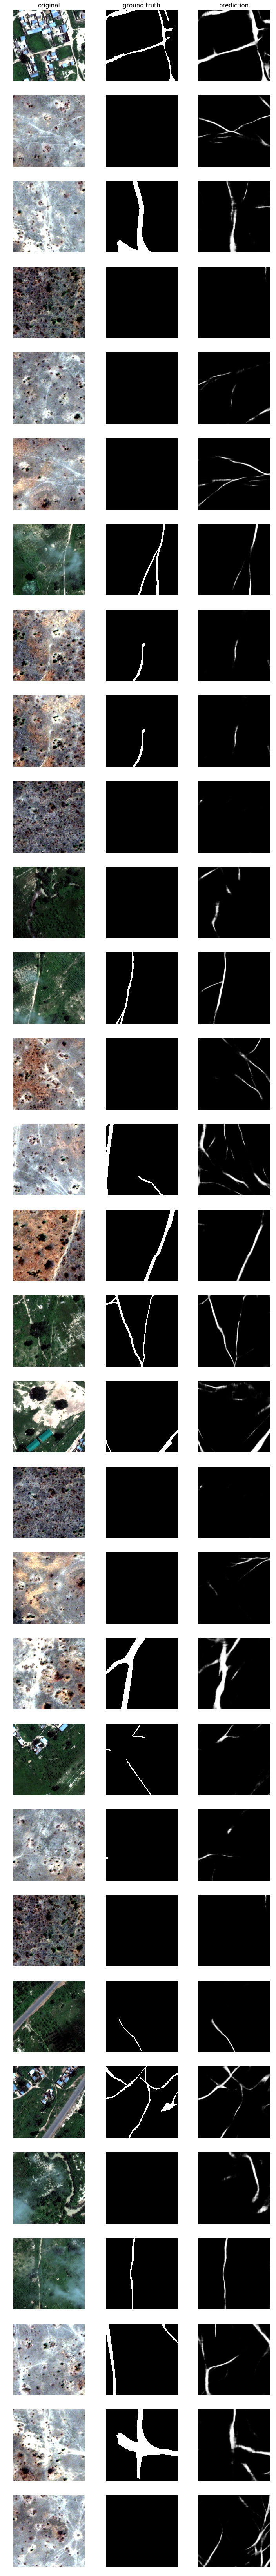

In [27]:
import matplotlib.pyplot as plt
import random

nm_img_to_plot = 30
fig, axes = plt.subplots(nm_img_to_plot, 3, figsize=(3*4, nm_img_to_plot*4))
axes[0, 0].set_title("original", fontsize=15) 
axes[0, 1].set_title("ground truth", fontsize=15) 
axes[0, 2].set_title("prediction", fontsize=15) 
for m in range(0, nm_img_to_plot):
    im_id = random.randint(0, X_test.shape[0]-1)
    axes[m, 0].imshow(X_test[im_id])
    axes[m, 0].set_axis_off()
    axes[m, 1].imshow(y_test[im_id].reshape((IMG_SIZE,IMG_SIZE)), cmap='gray')
    axes[m, 1].set_axis_off()
    axes[m, 2].imshow(y_pred[im_id].reshape((IMG_SIZE,IMG_SIZE)), cmap='gray')
    axes[m, 2].set_axis_off()